In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langsmith import traceable
import os

In [2]:
os.environ["LANGSMITH_PROJECT"] = "Research_agent"

In [3]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(
    model_name="gpt-4o-mini",   
    openai_api_key=api_key,
    max_tokens=500             
)

In [4]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

In [5]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)


In [6]:
graph

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph after 1 retries. To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [7]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Chen
Affiliation: Tech Innovations Research Group
Role: AI Framework Specialist
Description: Dr. Emily Chen focuses on the technical capabilities and improvements that LangGraph offers as an agent framework. She is concerned with its scalability, performance, and how it compares with existing frameworks in the market.
--------------------------------------------------
Name: Mr. Alex Johnson
Affiliation: Business Intelligence Institute
Role: Data Strategy Analyst
Description: Mr. Alex Johnson explores the business implications of adopting LangGraph, including cost-benefit analysis, ROI, and how its implementation can enhance operational efficiency and decision-making processes for companies.
--------------------------------------------------
Name: Dr. Patricia Santos
Affiliation: AI Ethics and Governance Council
Role: Ethics and Compliance Advisor
Description: Dr. Patricia Santos addresses the ethical considerations and compliance issues associated with the adoption of L

In [8]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [9]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f084202-cbff-6af4-8002-f98d933fbdac'}}

In [10]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: Tech Innovations Research Group
Role: AI Framework Specialist
Description: Dr. Emily Chen focuses on the technical capabilities and improvements that LangGraph offers as an agent framework. She is concerned with its scalability, performance, and how it compares with existing frameworks in the market.
--------------------------------------------------
Name: Mr. Alex Johnson
Affiliation: Business Intelligence Institute
Role: Data Strategy Analyst
Description: Mr. Alex Johnson explores the business implications of adopting LangGraph, including cost-benefit analysis, ROI, and how its implementation can enhance operational efficiency and decision-making processes for companies.
--------------------------------------------------
Name: Dr. Patricia Santos
Affiliation: AI Ethics and Governance Council
Role: Ethics and Compliance Advisor
Description: Dr. Patricia Santos addresses the ethical considerations and compliance issues associated with the adoption of L

In [11]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f084203-7e2d-6d6d-8004-441f6262f9c0'}}

In [12]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [13]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [14]:
final_state.next

()

In [15]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Emily Chen
Affiliation: Tech Innovations Inc.
Role: Lead Research Scientist
Description: Dr. Chen focuses on the technical capabilities and advantages of LangGraph, particularly its ability to integrate with various AI models to enhance operational efficiency and decision making. Her research emphasizes the transformational impact of LangGraph on traditional workflows in large organizations.
--------------------------------------------------
Name: Marcus Lee
Affiliation: Startup Growth Labs
Role: Co-Founder & CEO
Description: Marcus, as a startup entrepreneur, explores how LangGraph can enable rapid development and deployment of AI solutions for new ventures. He is particularly interested in the framework's potential to reduce time-to-market and the costs associated with scaling AI capabilities in startups.
--------------------------------------------------
Name: Linda Garcia
Affiliation: Industry Consultants Group
Role: Senior Analyst
Description: Linda specializes in market

In [7]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [8]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

In [9]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_api_key = os.getenv("TAVILY_API_KEY")
tavily_search = TavilySearchResults(max_results=3)

C:\Users\M.Zaid Naeem\AppData\Local\Temp\ipykernel_12888\1880834261.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search = TavilySearchResults(max_results=3)


In [10]:
from langchain_community.document_loaders import WikipediaLoader

from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]

    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")


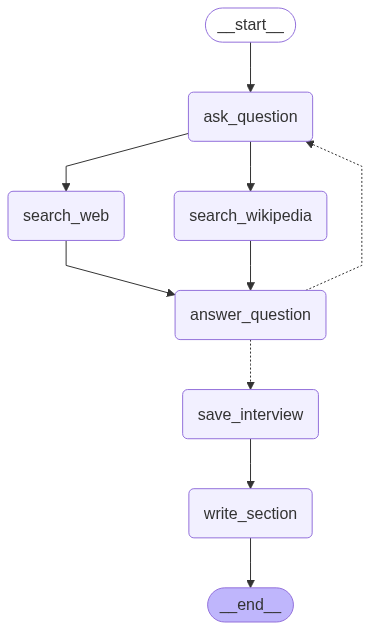

In [25]:
interview_graph

In [26]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovations Inc.', name='Dr. Emily Chen', role='Lead Research Scientist', description='Dr. Chen focuses on the technical capabilities and advantages of LangGraph, particularly its ability to integrate with various AI models to enhance operational efficiency and decision making. Her research emphasizes the transformational impact of LangGraph on traditional workflows in large organizations.')

In [27]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Transforming Workflows with LangGraph: A Comprehensive Framework for AI Agents

### Summary
LangGraph is revolutionizing the development of AI agents and applications by emphasizing stateful, cyclical workflows, which are vital for implementing agent-like behaviors. Traditional approaches to AI often follow a Directed Acyclic Graph (DAG) framework, which limits interactivity and iterative learning; however, LangGraph provides explicit support for cycles that allow agents to continuously refine their decision-making processes [1]. This innovative capability enhances the operational efficiency of organizations by enabling the creation of sophisticated agents capable of handling extended, meaningful dialogues—efficiently serving as virtual assistants, customer service bots, and more [1][2].

Notably, organizations across diverse sectors have harnessed LangGraph to enhance their operational frameworks. For instance, Norwegian Cruise Line has utilized LangGraph to construct personalized AI solutions, leading to improved guest experiences. Similarly, companies like AppFolio and Uber have reported substantial time savings and increased accuracy in decision-making through LangGraph's capabilities [2][4]. The ability to manage conversational contexts adeptly and integrate seamlessly with other tools makes LangGraph an indispensable resource for developing highly coordinated workflows [2][3].

In addition to its robust state management, LangGraph supports various agent-based systems utilized in fields such as robotics, autonomous vehicles, and gaming applications [2]. It integrates smoothly with existing frameworks, enhancing flexibility and scalability while applying advanced functionality [3][4]. The feedback loop inherent in LangGraph's design allows for continuous adaptation and learning, a feature that is increasingly becoming a requirement in fast-paced operational environments [1][4].

Moreover, LangGraph excels in the context of real-time applications such as threat detection and hiring processes at companies like Elastic and LinkedIn, demonstrating its versatility across different industries [2][4]. The advanced capabilities to encapsulate context, perform periodic summarization, and manage diverse user interactions elevate its role in future AI developments [5]. 

The insights gained from various implementations underscore LangGraph's potential not just as a tool but as a transformative framework that can significantly shift how large organizations approach workflows and AI.

### Sources
[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[2] https://www.ibm.com/think/topics/langgraph  
[3] https://galileo.ai/blog/mastering-agents-langgraph-vs-autogen-vs-crew  


In [11]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [15]:
from langgraph.types import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analysts"

    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    sections = state["sections"]
    topic = state["topic"]

    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)


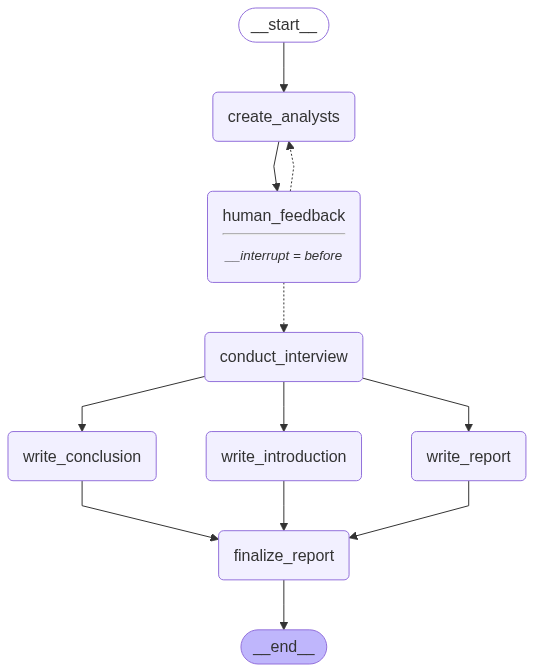

In [17]:
graph

In [18]:
# Inputs
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on evaluating how new technologies, like LangGraph, can enhance the efficiency and effectiveness of AI systems in various industries. Her insights center on integration capabilities, cost-effectiveness, and the impact on productivity.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Future AI Research Group
Role: Machine Learning Researcher
Description: Michael Thompson is dedicated to exploring the algorithmic advantages of LangGraph. He examines the performance improvements, scalability, and machine learning optimizations that LangGraph brings as an agent framework compared to traditional methods.
--------------------------------------------------
Name: Sophia Chen
Affiliation: Business Tech Solutions
Role: Business Technology Analyst
Description: Sophia Chen analyzes the business implications of adopting LangGraph. She evaluate

In [19]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0842d4-d059-6cef-8002-78bc59c4a73f'}}

In [20]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on evaluating how new technologies, like LangGraph, can enhance the efficiency and effectiveness of AI systems in various industries. Her insights center on integration capabilities, cost-effectiveness, and the impact on productivity.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Future AI Research Group
Role: Machine Learning Researcher
Description: Michael Thompson is dedicated to exploring the algorithmic advantages of LangGraph. He examines the performance improvements, scalability, and machine learning optimizations that LangGraph brings as an agent framework compared to traditional methods.
--------------------------------------------------
Name: Sophia Chen
Affiliation: Business Tech Solutions
Role: Business Technology Analyst
Description: Sophia Chen analyzes the business implications of adopting LangGraph. She evaluate

In [21]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0842d4-f338-6fbd-8004-252ed92bbe2b'}}

In [23]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_report
--Node--
write_introduction
--Node--
finalize_report


In [24]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Unlocking AI Potential with LangGraph: A Flexible Framework for Model Interoperability

## Introduction

The rapid evolution of artificial intelligence demands frameworks that enhance the efficiency and interoperability of agent-based systems. LangGraph, developed by LangChain, rises to this challenge with its innovative graph-based architecture, enabling sophisticated workflows across diverse applications such as robotics and autonomous vehicles. This report explores the multifaceted benefits of adopting LangGraph, including its flexibility in supporting complex decision-making and cyclical workflows. We will also examine its capability for enhancing productivity in enterprises and startups, as well as its robust community support for continuous development. LangGraph not only redefines agent interactions but also optimizes operational efficiency, positioning itself as a transformative tool in the AI landscape.

---


LangGraph represents a watershed moment in the development of agent-based artificial intelligence (AI) frameworks, showcasing a robust architecture that enhances model interoperability and decision-making capabilities across various applications. Its graph-based design facilitates the structuring and management of complex workflows, crucial for sectors like robotics, autonomous vehicles, and enterprise solutions. Organizations, from startups to established giants, are increasingly recognizing its transformative potential.

One of LangGraph’s key advantages is its support for cyclical workflows, which allows for iterative learning and more sophisticated decision-making processes compared to traditional Direct Acyclic Graph (DAG) frameworks. This flexibility enables developers to implement dynamic behaviors in agents, fostering more human-like interactions and the ability to respond to evolving inputs in real time [1][2]. For instance, applications in recruitment can delegate tedious tasks like resume scanning to AI agents, freeing human resources to focus on strategic talent engagement.

LangGraph’s architecture also offers distinct control over multiple agent interactions, allowing different phases of workflows to operate concurrently or pause for human input [2]. This capacity for nuanced decision-making enhances the cognitive capabilities of automated systems, resulting in improved operational efficiency and reduced complexity.

Moreover, LangGraph's modularity is crucial for startups looking to deploy advanced AI solutions without substantial infrastructure investments. By promoting rapid iteration, teams can fine-tune workflows and enhance transparency in AI project management. Early adopters like Replit, Uber, and AppFolio have effectively utilized LangGraph to accelerate development cycles and realize significant productivity gains [3][4][5].

The framework’s emphasis on visualizing agent interactions further simplifies debugging and understanding user workflows, allowing engineers to scale agent capabilities responsively. This is critical in a business landscape where 70% of organizations highlight scalability challenges as a primary concern [2]. LangGraph’s intuitive interface supports effective problem-solving and reduces operational burdens—enabling organizations to leverage AI more effectively while keeping a lid on costs.

As an open-source platform, LangGraph encourages ongoing community contributions, allowing integration with state-of-the-art language models, ultimately fostering customization and adaptability specific to operational needs. This community backing not only accelerates user onboarding but also results in enhanced support throughout development timelines.

Overall, LangGraph stands as a compelling solution poised to elevate AI capabilities across industries, offering flexibility, scalability, and enhanced operational efficiency for organizations looking to thrive in an increasingly AI-driven world.


---

## Conclusion

LangGraph stands out as a transformative framework for AI development, particularly in enhancing agent-based systems across various sectors. Its innovative graph-based architecture facilitates increased model interoperability, enabling complex workflows and iterative learning critical for modern applications. The framework's flexibility accommodates diverse agent interactions, effectively addressing the limitations of previous models like LangChain. Furthermore, LangGraph's visual modeling capabilities simplify debugging and scalability, making it an attractive option for organizations from established enterprises to agile startups. Overall, adopting LangGraph not only streamlines AI integration but significantly boosts operational efficiency, empowering businesses to harness advanced AI capabilities in a competitive landscape.

## Sources
[1] https://www.ibm.com/think/topics/langgraph  
[2] https://medium.com/@ke